# Run the simulation notebook for one set of parameters

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from gammapy.datasets import Datasets
from gammapy.estimators import ExcessMapEstimator
from simulation_extended import *
from regions import CircleSkyRegion

In [2]:
simulator = Simulation()
estimator = ExcessMapEstimator(correlation_radius=0.3*u.deg,
                             selection_optional=None)

In [3]:
%%time
sigma = 0.3*u.deg
n_obs = 4
datasets = simulator.run(n_obs=n_obs, sigma=sigma)

Pointing position: 
 <SkyCoord (Galactic): (l, b) in deg
    (0.7, 0.)>
Pointing position: 
 <SkyCoord (Galactic): (l, b) in deg
    (359.3, 0.)>
Pointing position: 
 <SkyCoord (Galactic): (l, b) in deg
    (0., 0.7)>
Pointing position: 
 <SkyCoord (Galactic): (l, b) in deg
    (0., -0.7)>
CPU times: user 22.5 s, sys: 4.68 s, total: 27.1 s
Wall time: 27.2 s


In [4]:
stacked = datasets.stack_reduce()

(array([1., 0., 0., 3., 3., 3., 1., 2., 2., 1.]),
 array([0.54771058, 0.6370442 , 0.72637783, 0.81571146, 0.90504508,
        0.99437871, 1.08371233, 1.17304596, 1.26237959, 1.35171321,
        1.44104684]),
 <BarContainer object of 10 artists>)

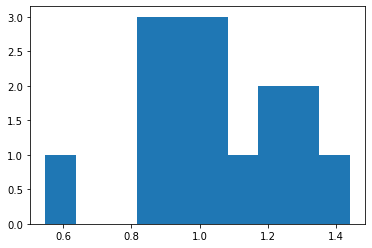

In [5]:
plt.hist(simulator.bkg_norms)

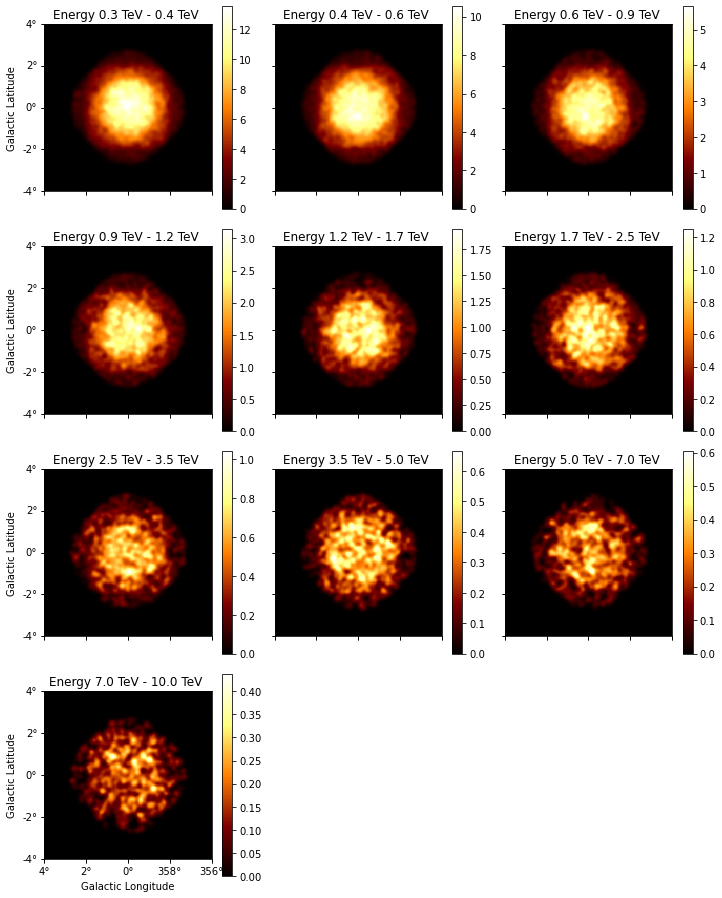

In [6]:
stacked.counts.smooth(0.1*u.deg).plot_grid(add_cbar=True);

/opt/anaconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


(<Figure size 432x288 with 2 Axes>,
 <WCSAxesSubplot:xlabel='Galactic Longitude', ylabel='Galactic Latitude'>,
 <matplotlib.colorbar.Colorbar at 0x1674d7eb8>)

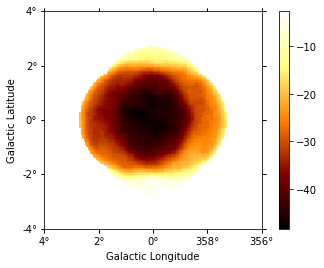

In [7]:
residual1 = estimator.run(stacked)
residual1['sqrt_ts'].plot(add_cbar=True)

In [8]:
#Source strength as a fraction of background
region = CircleSkyRegion(center=simulator.skydir,
                        radius=1.0*sigma)
bkg_strength = stacked.background.get_spectrum(region).data.sum()
src_strength = stacked.counts.get_spectrum(region).data.sum()
print(src_strength/bkg_strength - 1.0)

-0.4574953323770661


## Extract with the ring background

In [9]:
from ring_background import *

In [10]:
stacked_on_off = extract_ring(datasets=datasets,
                             radius=sigma,
                             r_in=1.0*u.deg,
                             source_pos=simulator.skydir
                             )

/opt/anaconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/opt/anaconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/opt/anaconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/opt/anaconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/opt/anaconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value

/opt/anaconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


(<Figure size 432x288 with 2 Axes>,
 <WCSAxesSubplot:xlabel='Galactic Longitude', ylabel='Galactic Latitude'>,
 <matplotlib.colorbar.Colorbar at 0x16f859cc0>)

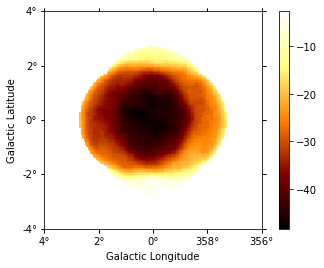

In [13]:
residual2 = estimator.run(stacked)
residual2['sqrt_ts'].plot(add_cbar=True)